## Example 2 - Mediators

Here, we examine the effect of ENSO on winter precipitation (Dec-Jan-Feb) in California (CA), which we assume is fully mediated by the position of the North Pacific jet stream (Jet). 

<img src="../images/ex2.png" width="500" height="600">


### References / Notes

1. The link between ENSO and California precipitation is for example described in https://iopscience.iop.org/article/10.1088/1748-9326/11/5/054021/ampdf
2. The California region is described in https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2015GL064424
3. The variable Jet is defined as 24-hour differences of Mean Sea Level Pressure, following also https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2015GL064424


### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt

import statsmodels.api as sm
from scipy import signal

### Step 1) Load the data + plot time series

In [8]:
jet = iris.load_cube('./sample_data/cali_jet_mean.nc')
ca = iris.load_cube('./sample_data/cali_precip_mean.nc', 'Monthly Mean of Precipitation Rate')
enso = iris.load_cube('./sample_data/enso_djf.nc', 'enso')

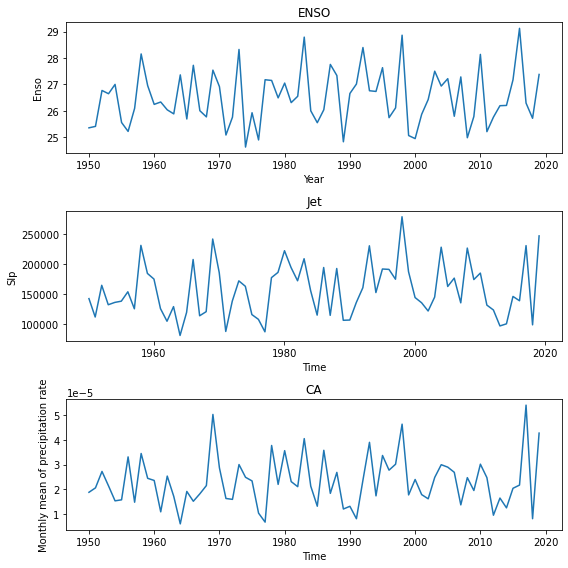

In [9]:
# PLOT raw data
fig = plt.figure(figsize=(8, 8))

plt.subplot(311)
qplt.plot(enso)
plt.title('ENSO')

plt.subplot(312)
qplt.plot(jet)
plt.title('Jet')

plt.subplot(313)
qplt.plot(ca)
plt.title('CA')
plt.tight_layout()



### Step 2)   Data Processing

#### Standardize the data (zero mean, unit variance)

In [10]:
ENSO = (enso - np.mean(enso.data))/np.std(enso.data)
JET = (jet - np.mean(jet.data))/np.std(jet.data)
CA = (ca - np.mean(ca.data))/np.std(ca.data)

#### Detrend

In [11]:
ENSO = signal.detrend(ENSO.data)
JET = signal.detrend(JET.data)
CA = signal.detrend(CA.data)

### Step 3)   Data Analysis

In [12]:
#================================================================
# Determine the effect of ENSO on CA conditioned on Jet
#================================================================

X = np.stack([ENSO, JET]).T
Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_enso_ca_cond_jet = results.params[0]
ce_jet_ca = results.params[1]

print("The regression coeff of ENSO on CA conditioned on Jet is ", round(ce_enso_ca_cond_jet,2))
print("The regression coeff. of Jet on CA is ", round(ce_jet_ca,2))

The regression coeff of ENSO on CA conditioned on Jet is  0.05
The regression coeff. of Jet on CA is  0.79


In [14]:
#================================================================
# Determine the causal effect of ENSO on CA 
#================================================================
X =  ENSO[:]
Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_enso_ca = results.params[0]

print("The causal effect of ENSO on CA is ", round(ce_enso_ca,2))

The causal effect of ENSO on CA is  0.34


In [15]:
#================================================================
# Determine the causal effect of ENSO on Jet
#================================================================
X =  ENSO[:]
Y = JET[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_enso_jet = results.params[0]

print("The causal effect of ENSO on Jet is ", round(ce_enso_jet,2))

The causal effect of ENSO on Jet is  0.37


In [16]:
#================================================================
# Determine the causal effect of Jet on CA
#================================================================
X =  JET[:]
Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_jet_ca = results.params[0]

print("The causal effect of Jet on CA is ", round(ce_jet_ca,2))

The causal effect of Jet on CA is  0.81


In [17]:
#=====================================================
# Path tracing rule:
#=====================================================

ce_along_path = ce_enso_jet * ce_jet_ca 


print("The indirectly estimated effect of ENSO on CA along the path ENSO -> Jet --> CA is ", round(ce_along_path ,2))
print("The directly estimated effect of ENSO on CA ", round(ce_enso_ca, 2))

The indirectly estimated effect of ENSO on CA along the path ENSO -> Jet --> CA is  0.3
The directly estimated effect of ENSO on CA  0.34


### Conclusions

Once we 'block' the pathway via Jet, i.e. by including it in the regression, the effect of ENSO to CA is reduced to almost zero. This is because its causal effect is mediated via Jet. 
